In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import seaborn as sns
# Use a clean seaborn style for better visuals
sns.set(style="whitegrid", context="talk", palette="colorblind")

In [18]:
# Load JSON file
with open('results.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
rows = []
for dataset, values in data['datasets'].items():
    if values['LagLLama_paper'] is not None and values["my_result"] != 0:
        rows.append({
            'dataset': dataset,
            'my_result': values['my_result'],
            'paper_mean': values['LagLLama_paper']['mean'],
            'paper_std': values['LagLLama_paper']['std']
        })

        print(f"{dataset} difference: {values['my_result'] - values['LagLLama_paper']['mean']}")

# Build DataFrame and filter out rows where our model produced 0
df = pd.DataFrame(rows)

AirQualityUCI difference: 0.016694363594940004
australian_electricity_demand difference: 0.05068997461525568
beijing_multisite difference: 0.01238774266622128
cpu_usage_minute difference: -0.0030919242638481337
electricity_hourly difference: 0.013679248278626197
ett_h1 difference: -0.0035917137936119087
ett_h2 difference: 0.00642411573178793
ett_m1 difference: -0.004900308967124137
function_delay_minute difference: 0.006080892065129989
instances_minute difference: 0.021189332798974232
kdd_cup_2018_without_missing difference: 0.01503287163674838
london_smart_meters_without_missing difference: 0.002849443122414974
memory_usage_minute difference: 0.0008724813949937005
solar_10_minutes difference: -0.17808468385968834
sunspot_without_missing difference: 0.7716176803390908
traffic difference: -0.0008026848104013967
uber_tlc_hourly difference: -0.007421817183210333
wind_farms_without_missing difference: -0.038429394076126014


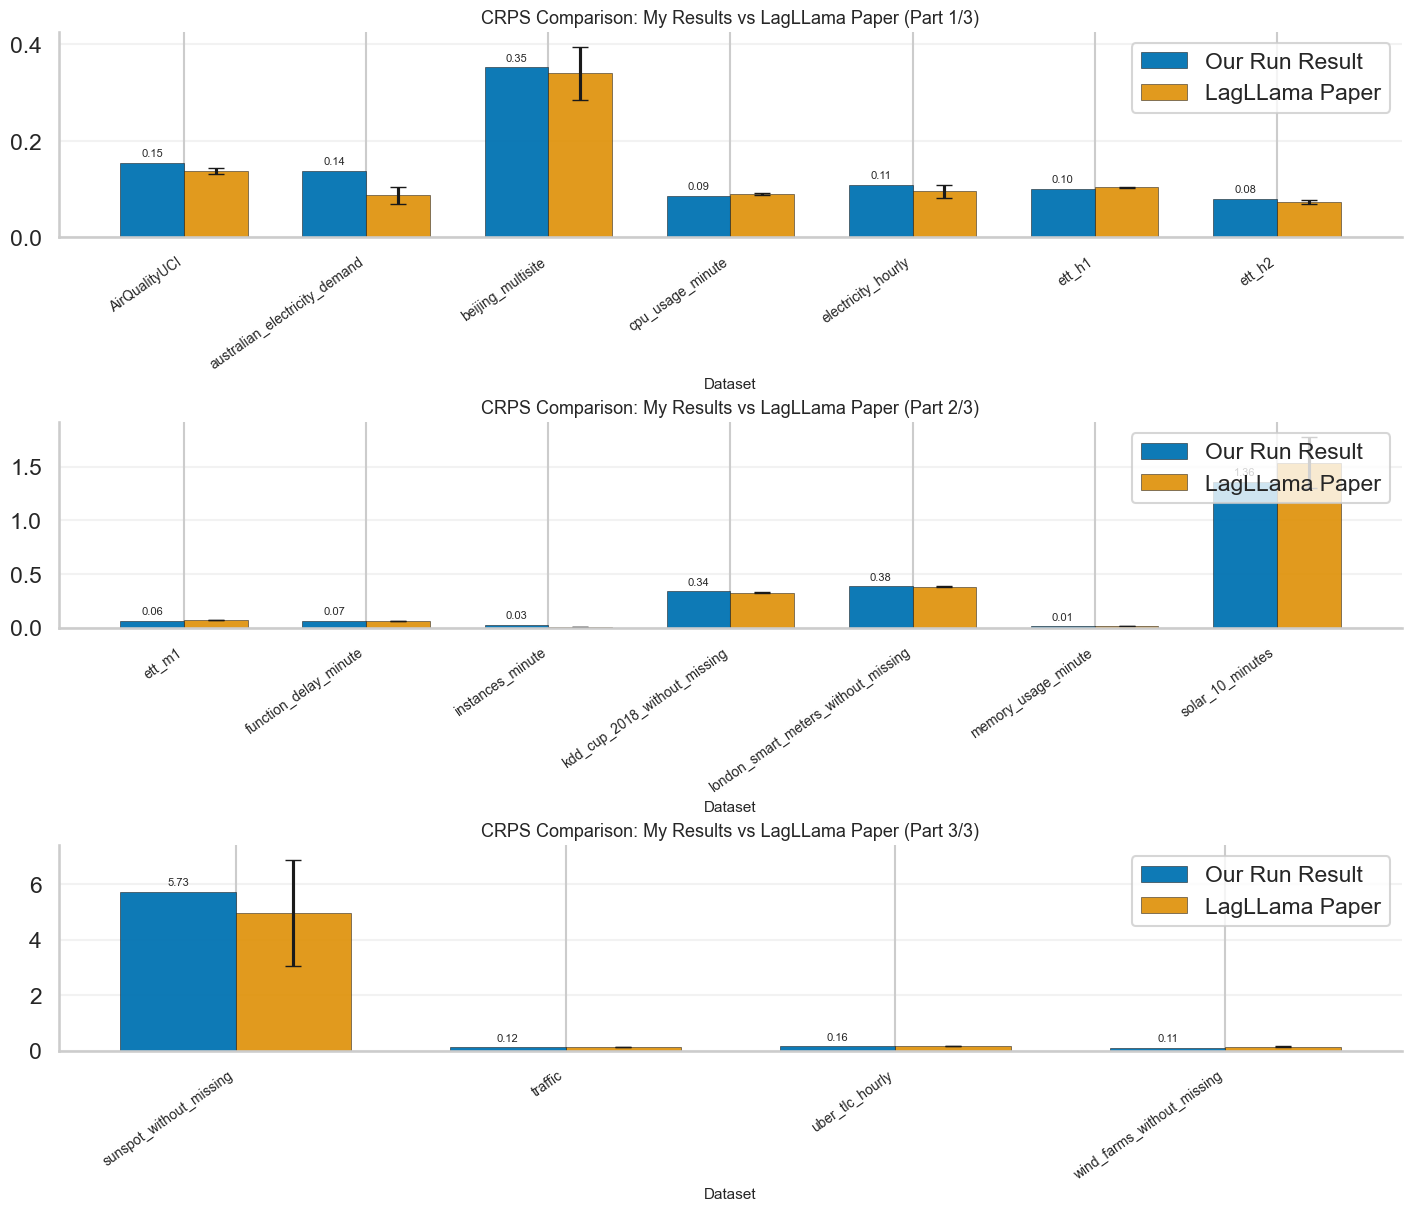

In [19]:
# Split into chunks for better readability
datasets_per_plot = 7
n_plots = int(np.ceil(len(df) / datasets_per_plot))

# Use seaborn palette and constrained layout for nicer spacing
palette = sns.color_palette("colorblind")
fig, axes = plt.subplots(n_plots, 1, figsize=(14, 4 * n_plots), constrained_layout=True)

# Handle single plot case
if n_plots == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    start_idx = i * datasets_per_plot
    end_idx = min((i + 1) * datasets_per_plot, len(df))
    df_chunk = df.iloc[start_idx:end_idx].reset_index(drop=True)

    x = np.arange(len(df_chunk))
    width = 0.35

    # Bars (our result and paper mean) with nicer styling
    bars1 = ax.bar(x - width/2, df_chunk['my_result'], width, label='Our Run Result',
                   color=palette[0], edgecolor='k', linewidth=0.4, alpha=0.95)
    bars2 = ax.bar(x + width/2, df_chunk['paper_mean'], width,
                   yerr=df_chunk['paper_std'], label='LagLLama Paper',
                   color=palette[1], edgecolor='k', linewidth=0.4, alpha=0.9, capsize=6)

    # Automatic scale handling: if there are very small values relative to large ones, use symlog
    combined = np.concatenate([np.nan_to_num(df_chunk['my_result'].values, nan=0.0),
                           np.nan_to_num(df_chunk['paper_mean'].values, nan=0.0)])
    nonzero = np.abs(combined[combined != 0])
    max_val = np.nanmax(np.abs(combined)) if combined.size > 0 else 0
    min_nonzero = np.nanmin(nonzero) if nonzero.size > 0 else np.nan

    use_symlog = False
    if not np.isnan(min_nonzero) and min_nonzero > 0 and max_val > 0:
        ratio = max_val / min_nonzero
        # If ratio huge or min is orders of magnitude smaller, use symlog to visualize both
        if ratio > 1000 or min_nonzero < max_val * 1e-3:
            use_symlog = True

    if use_symlog:
        linthresh = max(min_nonzero * 10, 1e-6)
        ax.set_yscale('symlog', linthresh=linthresh)
        ax.set_ylabel('CRPS (symlog scale)', fontsize=11)
    else:
        # Tighten y-limits for better visual comparison
        vals = np.concatenate([df_chunk['my_result'].values, (df_chunk['paper_mean'] + df_chunk['paper_std']).values])
        y_max = np.nanmax(vals) if len(vals) > 0 else 1
        ax.set_ylim(0, y_max * 1.08)

    # Labels and formatting
    ax.set_xlabel('Dataset', fontsize=11)
    ax.set_title(f'CRPS Comparison: My Results vs LagLLama Paper (Part {i+1}/{n_plots})', fontsize=13)
    ax.set_xticks(x)
    ax.set_xticklabels(df_chunk['dataset'], rotation=35, ha='right', fontsize=10)
    ax.legend(loc='upper right', frameon=True)
    ax.grid(axis='y', alpha=0.25)

    # Annotate our bars with values
    for p in bars1:
        h = p.get_height()
        if not np.isnan(h):
            ax.annotate(f"{h:.2f}", (p.get_x() + p.get_width() / 2, h),
                        ha="center", va="bottom", fontsize=8, xytext=(0, 3), textcoords="offset points")

    # Remove top/right spines for a cleaner look
    sns.despine(ax=ax)

plt.savefig('crps_comparison.png', dpi=180, bbox_inches='tight')
plt.show()